# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [ ]:
# Intstall PyTorch and download data
!pip3 install torch torchvision

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2020-04-06 23:42:09--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  19.5MB/s    in 9.0s    

2020-04-06 23:42:19 (19.2 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2020-04-06 23:42:19--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  21.1MB/s    in 2.9s    

2020-04-06 23:42:21 (21.1 MB/s) - ‘test_32x32.mat’ saved [64275384/64275384]

FINISHED --2020-04-06 23:42:21--
Total wall clock time: 12s
Downloaded: 2 files, 235M in

In [ ]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [ ]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [ ]:
# First, lets load the dataset
data_train = dset.SVHN('./', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [ ]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [ ]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [ ]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [ ]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None,):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        if scheduler:
            scheduler.step()  # use the sheduler


        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    
    # raise Exception("Not implemented")
    correct_samples = 0
    total_samples = 0
    for (x, y) in loader:
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        
        prediction = model(x_gpu)    

        indices = torch.argmax(prediction, 1)
        correct_samples += torch.sum(indices == y_gpu)
        total_samples += y_gpu.shape[0]
    
    val_accuracy = float(correct_samples) / total_samples
    return val_accuracy




loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.407771, Train accuracy: 0.530355, Val accuracy: 0.729370
Average loss: 0.704501, Train accuracy: 0.786711, Val accuracy: 0.806088
Average loss: 0.597260, Train accuracy: 0.820530, Val accuracy: 0.814688
Average loss: 0.549296, Train accuracy: 0.834932, Val accuracy: 0.833390
Average loss: 0.521415, Train accuracy: 0.843429, Val accuracy: 0.848475


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [ ]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

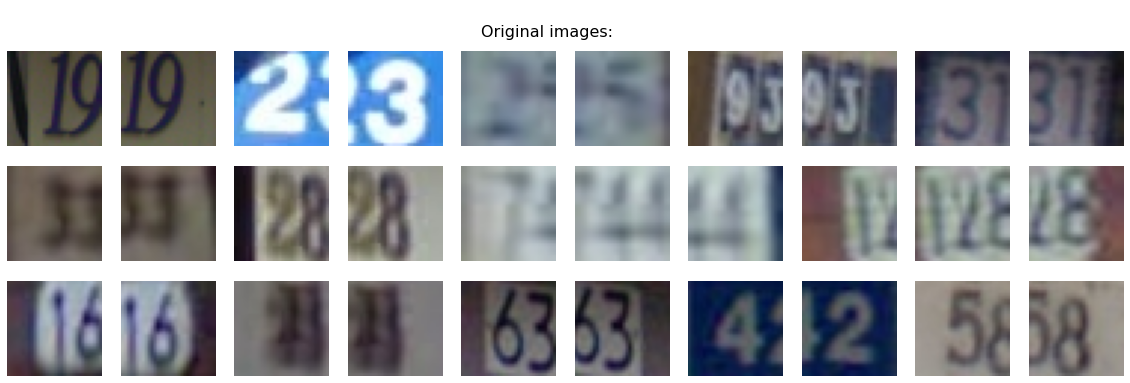

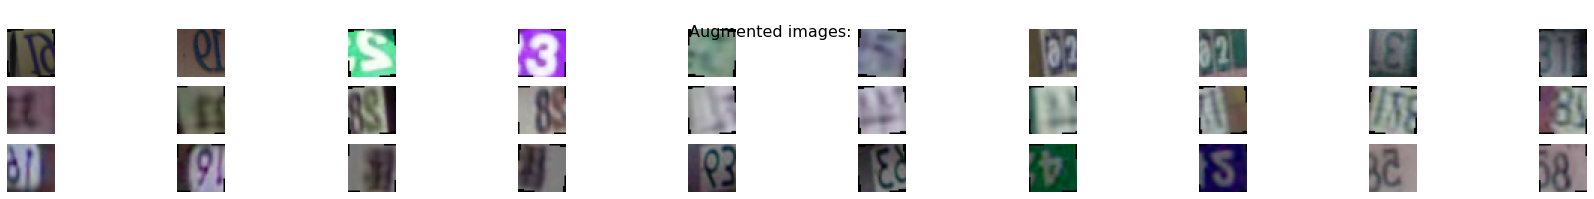

In [ ]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

rows = 3
cols = 10

fig = plt.figure(figsize=(20, 6))
fig.suptitle('\nOriginal images:', fontsize=16)

for i, (x, y) in enumerate(dset.SVHN('./')):
    if i == rows * cols:
        break
    plt.subplot(rows, cols, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')



tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./', 
                       transform=tfs
                      )

fig = plt.figure(figsize=(30, 3))
fig.suptitle('\nAugmented images:', fontsize=16)

for i, (x, y) in enumerate(data_aug_vis):
    if i == (rows * cols):
        break
    plt.subplot(rows, cols, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

In [ ]:
# TODO: 
tfs = transforms.Compose([
    # TODO: Add good augmentations
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# TODO create new instances of loaders with the augmentations you chose
data_aug_train = dset.SVHN('./', transform=tfs)
train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, sampler=train_sampler)

In [ ]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 0.610021, Train accuracy: 0.813108, Val accuracy: 0.852365
Average loss: 0.566076, Train accuracy: 0.830632, Val accuracy: 0.849498
Average loss: 0.544929, Train accuracy: 0.834283, Val accuracy: 0.826019
Average loss: 0.524016, Train accuracy: 0.841910, Val accuracy: 0.858167
Average loss: 0.512086, Train accuracy: 0.844060, Val accuracy: 0.848475


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [ ]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
              nn.Conv2d(3, 6, 5),
              nn.Tanh(),

              nn.MaxPool2d(2),

              nn.Conv2d(6, 16, 5),
              nn.Tanh(),

              nn.MaxPool2d(2),

              Flattener(),

              nn.Linear(5*5*16, 120),
              nn.Tanh(),

              nn.Linear(120, 84),
              nn.Tanh(),

              nn.Linear(84, 10),
              nn.Tanh()

          )

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [ ]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

Average loss: 1.690423, Train accuracy: 0.507661, Val accuracy: 0.781448
Average loss: 1.171785, Train accuracy: 0.809337, Val accuracy: 0.848679
Average loss: 1.102684, Train accuracy: 0.834880, Val accuracy: 0.855232
Average loss: 1.068513, Train accuracy: 0.848497, Val accuracy: 0.863286
Average loss: 1.050057, Train accuracy: 0.857438, Val accuracy: 0.870999
Average loss: 1.038526, Train accuracy: 0.861942, Val accuracy: 0.869497
Average loss: 1.026260, Train accuracy: 0.868904, Val accuracy: 0.875299
Average loss: 1.015679, Train accuracy: 0.874757, Val accuracy: 0.880418
Average loss: 1.009160, Train accuracy: 0.878613, Val accuracy: 0.879803
Average loss: 1.004532, Train accuracy: 0.880797, Val accuracy: 0.885264


In [ ]:
lenet_model = nn.Sequential(
              nn.Conv2d(3, 6, 5),
              nn.ReLU(inplace=True),

              nn.MaxPool2d(2),

              nn.Conv2d(6, 16, 5),
              nn.ReLU(inplace=True),

              nn.MaxPool2d(2),

              Flattener(),

              nn.Linear(5*5*16, 120),
              nn.ReLU(inplace=True),

              nn.Linear(120, 84),
              nn.ReLU(inplace=True),

              nn.Linear(84, 10),
              nn.ReLU(inplace=True),

          )

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [ ]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

Average loss: 1.847982, Train accuracy: 0.363086, Val accuracy: 0.678520
Average loss: 0.806410, Train accuracy: 0.751630, Val accuracy: 0.792915
Average loss: 0.647328, Train accuracy: 0.794919, Val accuracy: 0.805747
Average loss: 0.588919, Train accuracy: 0.810139, Val accuracy: 0.817965
Average loss: 0.547898, Train accuracy: 0.822117, Val accuracy: 0.820900
Average loss: 0.523557, Train accuracy: 0.828158, Val accuracy: 0.833322
Average loss: 0.363881, Train accuracy: 0.891137, Val accuracy: 0.888950
Average loss: 0.342339, Train accuracy: 0.897946, Val accuracy: 0.893318
Average loss: 0.324895, Train accuracy: 0.903508, Val accuracy: 0.890724
Average loss: 0.310014, Train accuracy: 0.908183, Val accuracy: 0.895024


In [ ]:
aaa = [1, 2, 3, 5]
print(aaa[-1])

5


# Подбор гиперпараметров

# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [ ]:
HyperParams = namedtuple("Hyperparams", ['learning_rate', 'reg_strength', 'epochs', 'step_size', 'gamma'])
RunResult = namedtuple("RunResult", ['model', 'loss_history', 'train_history', 'val_history'])

model = nn.Sequential(
                # 32x32@3 => 32x32@16
                nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=2),
                nn.BatchNorm2d(num_features=16),
                nn.ReLU(inplace=True),    

                # 32x32@16 => 16x16@16
                nn.MaxPool2d(kernel_size=2),

                # 16x16@16 => 14x14@32
                nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
                nn.BatchNorm2d(num_features=32),
                nn.ReLU(inplace=True),    

                # 14x14@32 => 7x7@32
                nn.MaxPool2d(kernel_size=2),

                # 7x7@32 => 5x5@64
                nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                nn.BatchNorm2d(num_features=64),
                nn.ReLU(inplace=True),

                Flattener(),

                nn.Linear(in_features=5*5*64, out_features=128),    
                nn.BatchNorm1d(num_features=128),
                nn.ReLU(inplace=True),

                nn.Linear(in_features=128, out_features=10)
            )
    
model.type(torch.cuda.FloatTensor)
model.to(device)


def search(stats, model, learning_rates, reg_strengths, epochs, step_size, gamma):            
    for learning_rate in learning_rates:
        for reg_strength in reg_strengths:           
            loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
            optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg_strength)
            #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=anneal_factor, patience=anneal_patience, verbose=True)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)  # add sheduler
   
            key = HyperParams(learning_rate, reg_strength, epochs, step_size, gamma)
            
            print('Training model: %s' % str(key))
            
            loss_history, train_history, val_history  = train_model(model, train_aug_loader, val_loader, loss, optimizer, epochs, scheduler=scheduler)                      
            value = RunResult(model, loss_history, train_history, val_history)            
            stats[key] = value
            
            print('\n')
    

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {}

In [ ]:
learning_rates = [1e-2, 1e-3]
reg_strengths = [1e-4, 1e-5]

#step_size = [2, 10, 15]
#gamma = [0.2, 0.5]
#step_size = 2, gamma = 0.2 test = 0.92689
#step_size = 15, gamma = 0.5 test = 

search(run_record, model, learning_rates, reg_strengths, epochs=15, step_size=15, gamma=0.5)

Training model: Hyperparams(learning_rate=0.01, reg_strength=0.0001, epochs=15, step_size=15, gamma=0.5)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Average loss: 0.362425, Train accuracy: 0.887708, Val accuracy: 0.900143
Average loss: 0.372723, Train accuracy: 0.885967, Val accuracy: 0.896731
Average loss: 0.370603, Train accuracy: 0.885575, Val accuracy: 0.897891
Average loss: 0.371067, Train accuracy: 0.886070, Val accuracy: 0.904989
Average loss: 0.365477, Train accuracy: 0.887093, Val accuracy: 0.889973
Average loss: 0.362860, Train accuracy: 0.888800, Val accuracy: 0.902054
Average loss: 0.362072, Train accuracy: 0.889397, Val accuracy: 0.898573
Average loss: 0.360674, Train accuracy: 0.889909, Val accuracy: 0.899939
Average loss: 0.359506, Train accuracy: 0.889499, Val accuracy: 0.904239


KeyboardInterrupt: ignored

In [ ]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.val_history:
        best_val_accuracy = run_result.val_history
        best_hyperparams = hyperparams
        best_run = run_result
        
print(best_val_accuracy[-1])
print(best_hyperparams)

best_model = run_record[best_hyperparams].model

0.9326325848064978
Hyperparams(learning_rate=0.001, reg_strength=0.0001, epochs=15, step_size=2, gamma=0.2)


In [ ]:
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(best_model, test_loader)
print( test_accuracy)

0.9268976644130301


In [ ]:
lenet_model = nn.Sequential(
            nn.Conv2d(3, 18, 5, padding=0), 
            nn.BatchNorm2d(18),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(2),
            nn.Conv2d(18, 24, 5, padding=0), 
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(2), 
            Flattener(), 
            nn.Linear(24*5*5, 200), 
            nn.BatchNorm1d(200), 
            nn.ReLU(inplace=True), 
            nn.Linear(200, 84),  
            nn.ReLU(inplace=True), 
            nn.Linear(84, 10), 
          )
lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 20)

Average loss: 0.770165, Train accuracy: 0.755656, Val accuracy: 0.844720
Average loss: 0.462907, Train accuracy: 0.858837, Val accuracy: 0.879940
Average loss: 0.398329, Train accuracy: 0.878050, Val accuracy: 0.898710
Average loss: 0.358607, Train accuracy: 0.889892, Val accuracy: 0.900007
Average loss: 0.327522, Train accuracy: 0.900283, Val accuracy: 0.906832
Average loss: 0.302920, Train accuracy: 0.907859, Val accuracy: 0.910518
Average loss: 0.287619, Train accuracy: 0.910999, Val accuracy: 0.905126
Average loss: 0.267829, Train accuracy: 0.917534, Val accuracy: 0.908880
Average loss: 0.256674, Train accuracy: 0.921424, Val accuracy: 0.907856
Average loss: 0.242860, Train accuracy: 0.925503, Val accuracy: 0.913999
Average loss: 0.228991, Train accuracy: 0.930195, Val accuracy: 0.914067
Average loss: 0.225047, Train accuracy: 0.930110, Val accuracy: 0.909016
Average loss: 0.216423, Train accuracy: 0.933898, Val accuracy: 0.917071
Average loss: 0.206350, Train accuracy: 0.935809, V

In [ ]:
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(lenet_model, test_loader)
print( test_accuracy)

0.9119929317762754
